In [27]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import mlab
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
matplotlib.style.use('ggplot')
import sqlite3
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# Importing the Dataset and performing EDA

In [2]:
url = "https://data.ny.gov/api/views/py8k-a8wg/rows.csv?accessType=DOWNLOAD"
mta_2020 = pd.read_csv(url)

In [3]:
mta_2020.head()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,03:00:00,REGULAR,7324295,2482512
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,07:00:00,REGULAR,7324305,2482523
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,11:00:00,REGULAR,7324371,2482594
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,15:00:00,REGULAR,7324587,2482647
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,19:00:00,REGULAR,7324963,2482713


Standardizing column names


In [4]:
def standardize_column_names(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(r'\s', '_', regex=True)  # Replace any whitespace character(s)
    )
    return df


In [5]:
standardize_column_names(mta_2020)
mta_2020.head()

,c/a,unit,scp,station,line_name,division,date,time,description,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,03:00:00,REGULAR,7324295,2482512
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,07:00:00,REGULAR,7324305,2482523
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,11:00:00,REGULAR,7324371,2482594
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,15:00:00,REGULAR,7324587,2482647
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,19:00:00,REGULAR,7324963,2482713


In a perfect world we would have a 1-to-1 ratio for entries and exits. Everyone person entering and exiting from the train station would be accounted for. As we can see, that is not the case. The average for entries is significantly higher than the average number of exits. This suggests that a large amount of people who leave are not being tracked.

The missing information is likely due to people opting to exit from emergency exit doors which cannot record how many people pass through it, both for entries and exits.

In [6]:
mta_2020['entries'].describe()

count    1.331800e+07
mean     4.272843e+07
std      2.183887e+08
min      0.000000e+00
25%      2.865048e+05
50%      1.801227e+06
75%      6.457238e+06
max      2.128896e+09
Name: entries, dtype: float64

In [7]:
mta_2020['exits'].describe()

count    1.331800e+07
mean     3.500043e+07
std      1.983066e+08
min      0.000000e+00
25%      1.242690e+05
50%      1.048689e+06
75%      4.332490e+06
max      2.123502e+09
Name: exits, dtype: float64

Creating a column that indentifies each individual turnstile

In [8]:
mta_2020['turnstile_id'] = mta_2020['c/a'] + ' ' + mta_2020['unit'] + ' ' + mta_2020['scp']
mta_2020['turnstile_id'].head()

0    A002 R051 02-00-00
1    A002 R051 02-00-00
2    A002 R051 02-00-00
3    A002 R051 02-00-00
4    A002 R051 02-00-00
Name: turnstile_id, dtype: object

In [9]:
mta_2020.isnull().sum()

c/a             0
unit            0
scp             0
station         0
line_name       0
division        0
date            0
time            0
description     0
entries         0
exits           0
turnstile_id    0
dtype: int64

There are no nulls in our dataset but is this really true?

In [10]:
zero_counts = {
    'entries': (mta_2020['entries'] == 0).sum(),
    'exits': (mta_2020['exits'] == 0).sum()
}
print(zero_counts)

{'entries': 193019, 'exits': 518993}


In [11]:
mta_2020.groupby('turnstile_id').count()

,c/a,unit,scp,station,line_name,division,date,time,description,entries,exits
turnstile_id,,,,,,,,,,,
A002 R051 02-00-00,2702,2702,2702,2702,2702,2702,2702,2702,2702,2702,2702
A002 R051 02-00-01,2705,2705,2705,2705,2705,2705,2705,2705,2705,2705,2705
A002 R051 02-03-00,2704,2704,2704,2704,2704,2704,2704,2704,2704,2704,2704
A002 R051 02-03-01,2704,2704,2704,2704,2704,2704,2704,2704,2704,2704,2704
A002 R051 02-03-02,2703,2703,2703,2703,2703,2703,2703,2703,2703,2703,2703
...,...,...,...,...,...,...,...,...,...,...,...
TRAM2 R469 00-00-01,2695,2695,2695,2695,2695,2695,2695,2695,2695,2695,2695
TRAM2 R469 00-03-00,2693,2693,2693,2693,2693,2693,2693,2693,2693,2693,2693
TRAM2 R469 00-03-01,2695,2695,2695,2695,2695,2695,2695,2695,2695,2695,2695


I'm going to find the busiest stations. I think it's useful to visualize which areas are extremely likely to have the highest rates of fare evasion because of their overall traffic.

In [12]:
# Sum entries and exits for each station
busiest_stations = (
    mta_2020.groupby('station')[['entries', 'exits']]
    .sum()
    .assign(total=lambda df: df['entries'] + df['exits'])  # total traffic
    .sort_values('total', ascending=False)
)

# Show top 10 busiest stations
print(busiest_stations.head(10))


                        entries           exits           total
station                                                        
42 ST-PORT AUTH  20295325156258  16787769592307  37083094748565
23 ST            15487678184877  15506763733635  30994441918512
161/YANKEE STAD  14522683282767  13935519844384  28458203127151
125 ST           16095106741387  10134049381728  26229156123115
DEKALB AV        15368441579484  10813070126682  26181511706166
34 ST-PENN STA   12629077447530  13547675560351  26176753007881
CANAL ST         10885709756153  14637968278977  25523678035130
34 ST-HERALD SQ  11196613686432  14187421348225  25384035034657
FULTON ST        12193190058932  12298254926735  24491444985667
TIMES SQ-42 ST   12218242578599   9765347596116  21983590174715


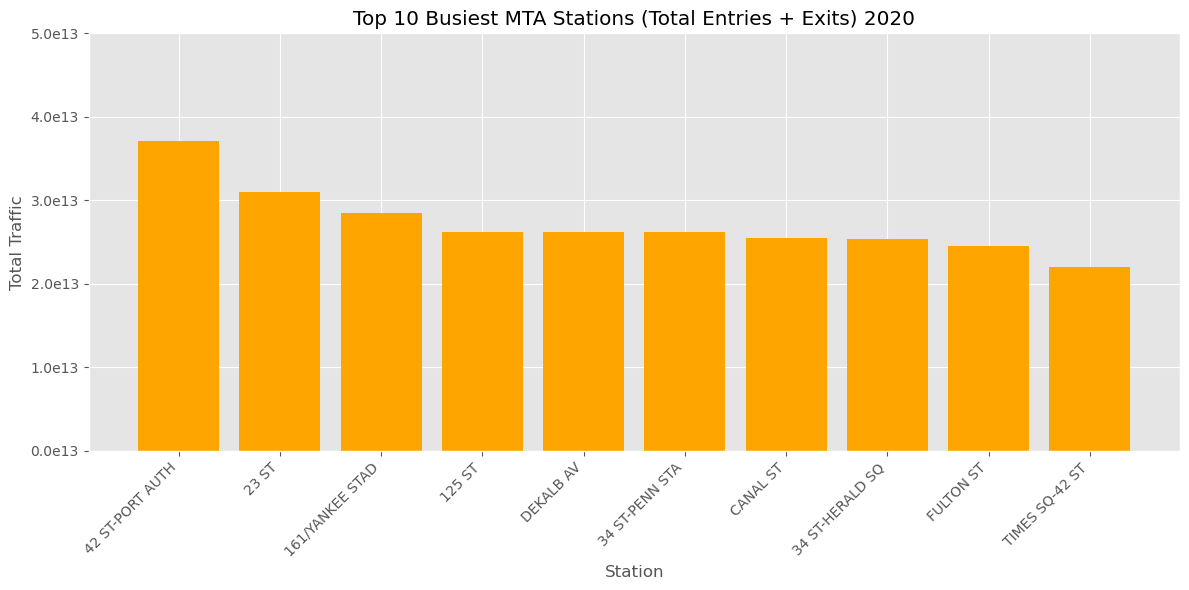

In [52]:
# Getting the top 10 busiest stations
top10 = busiest_stations.head(10).reset_index()


plt.figure(figsize=(12, 6))

# Standardize the axis for easier comparion b/w years
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*1e-13:.1f}e13'))
plt.ylim(0, 0.5e14)

plt.bar(top10['station'], top10['total'], color='orange')
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Busiest MTA Stations (Total Entries + Exits) 2020")
plt.xlabel("Station")
plt.ylabel("Total Traffic")
plt.tight_layout()
plt.show()


I'm going to do the same for the train lines to see which are used the most.

In [32]:
busiest_lines = (
    mta_2020.groupby('line_name')[['entries', 'exits']]
    .sum()
    .assign(total=lambda df: df['entries'] + df['exits'])
    .sort_values('total', ascending=False)
)

In [33]:
# Step 1: Make a copy to avoid changing the original
lines_expanded = mta_2020.copy()

# Step 2: Split by space (e.g., "A C E" → ["A", "C", "E"])
lines_expanded['line_name'] = lines_expanded['line_name'].str.split()

# Step 3: Explode into multiple rows
lines_expanded = lines_expanded.explode('line_name')

# Step 4: Group by each individual line
busiest_individual_lines = (
    lines_expanded.groupby('line_name')[['entries', 'exits']]
    .sum()
    .assign(total=lambda df: df['entries'] + df['exits'])
    .sort_values('total', ascending=False)
)


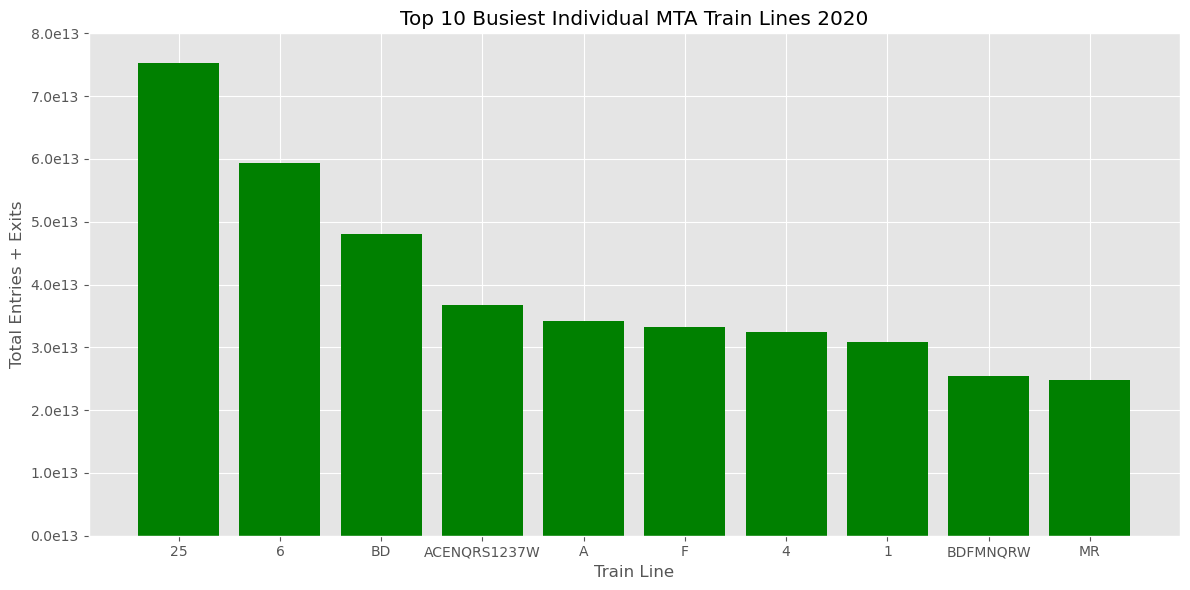

In [53]:
top_lines = busiest_individual_lines.head(10).reset_index()

plt.figure(figsize=(12, 6))

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*1e-13:.1f}e13'))
plt.ylim(0, .8e14)

plt.bar(top_lines['line_name'], top_lines['total'], color='green')
plt.xticks(rotation=0)
plt.title("Top 10 Busiest Individual MTA Train Lines 2020")
plt.xlabel("Train Line")
plt.ylabel("Total Entries + Exits")
plt.tight_layout()
plt.show()


Now I'm analyzing by time. This can give us an idea of when the MTA should request additional law enforcement presence to reduce the amount of fare evaders.

In [35]:
# Strip AM/PM from the time strings
mta_2020['time'] = mta_2020['time'].str.replace(r'\s?(AM|PM)', '', regex=True)

# Now combine and convert
mta_2020['datetime'] = pd.to_datetime(mta_2020['date'] + ' ' + mta_2020['time'])


Extracting parts of the datetime obj so we can look at what days were most busy and what hours of the day were most busy.

In [36]:
mta_2020['date_only'] = mta_2020['datetime'].dt.date
mta_2020['hour'] = mta_2020['datetime'].dt.hour

In [37]:
daily_traffic = (
    mta_2020.groupby('date_only')[['entries', 'exits']]
    .sum()
    .assign(total=lambda df: df['entries'] + df['exits'])
)

In [38]:
hourly_traffic = (
    mta_2020.groupby('hour')[['entries', 'exits']]
    .sum()
    .assign(total=lambda df: df['entries'] + df['exits'])
)


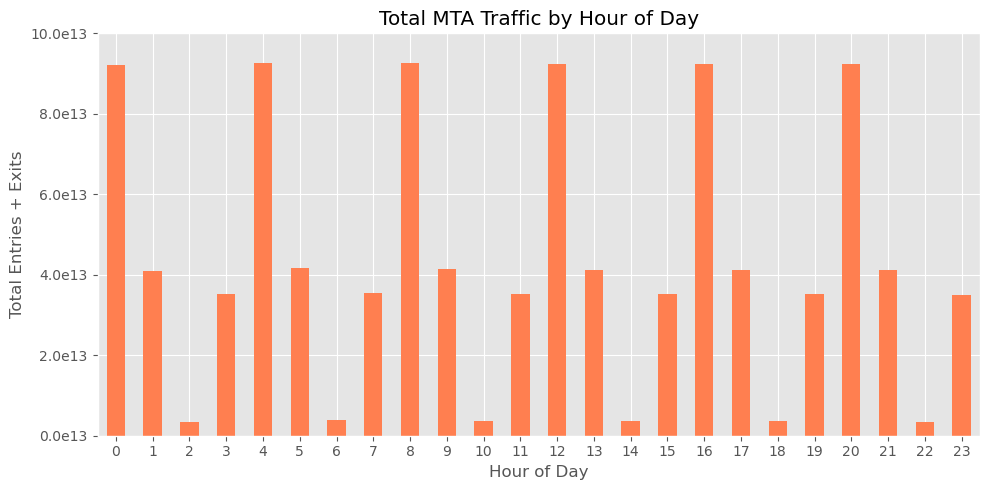

In [43]:
hourly_traffic.plot(
    y='total', kind='bar', legend=False, figsize=(10, 5), color='coral',
    title='Total MTA Traffic by Hour of Day'
)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*1e-13:.1f}e13'))
plt.ylim(0, 1e14)

plt.xlabel("Hour of Day")
plt.ylabel("Total Entries + Exits")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

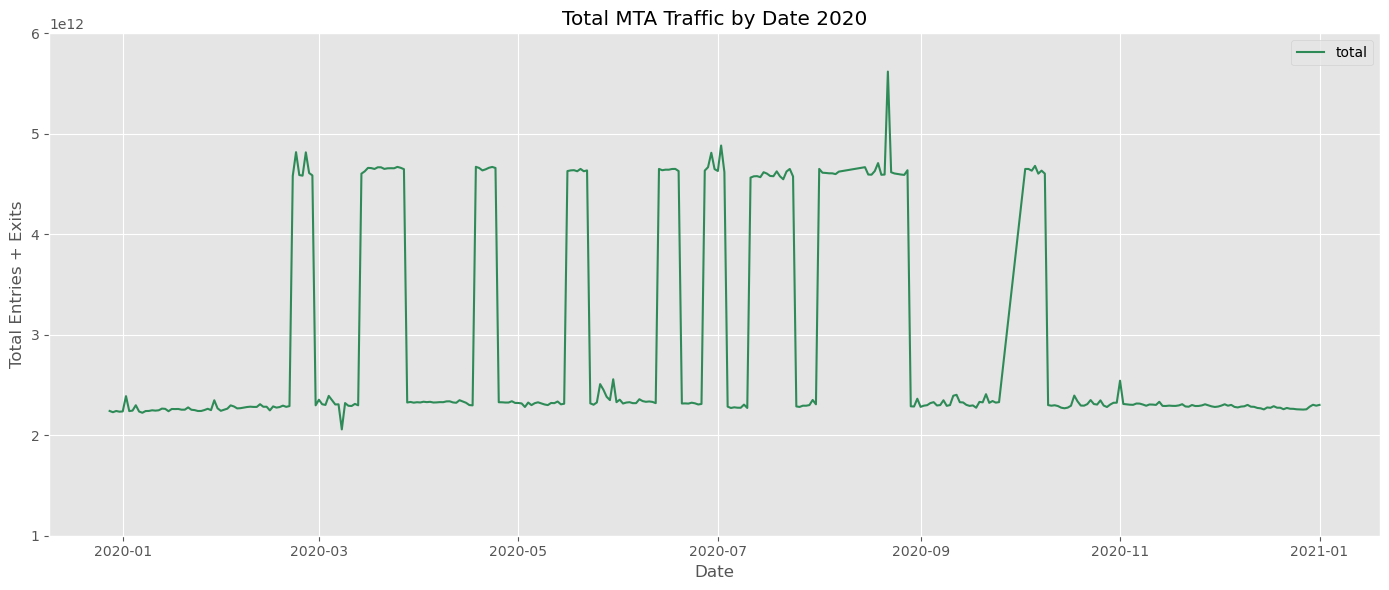

In [54]:
daily_traffic.plot(
    y='total', figsize=(14, 6), title='Total MTA Traffic by Date 2020', color='seagreen'
)

# plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*1e-13:.1f}e13'))
# plt.ylim(0, 1e14)

plt.ylim(1e12, 6e12)
plt.xlabel("Date")
plt.ylabel("Total Entries + Exits")
plt.tight_layout()
plt.show()


Which days of the week are the most busy? Additional law enforcement then could also be beneficial.

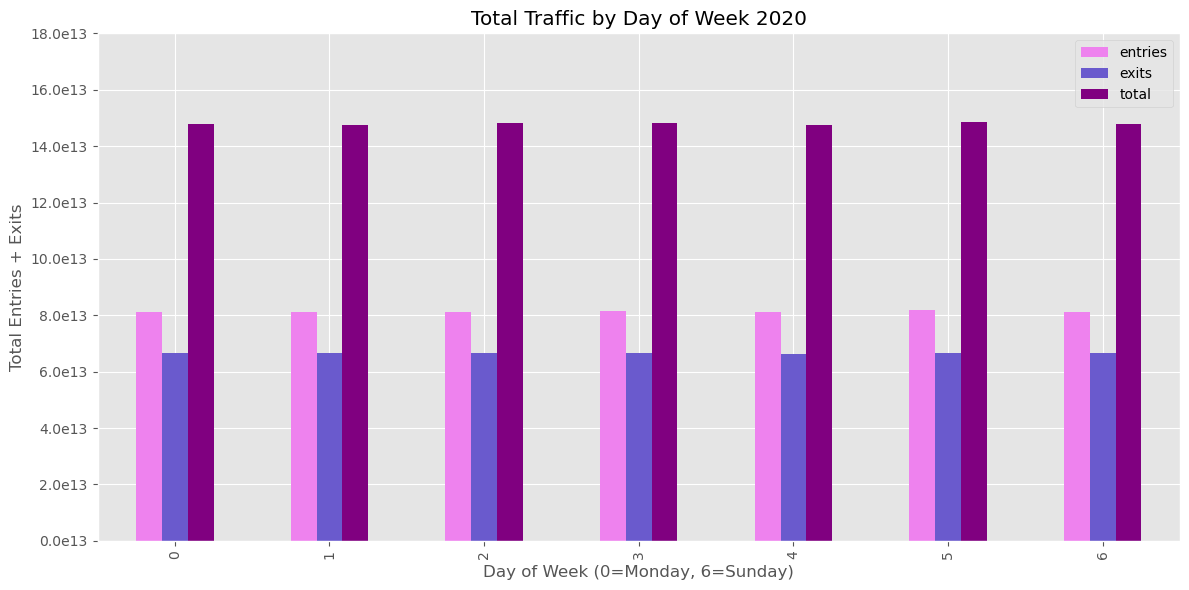

In [55]:
mta_2020['weekday'] = mta_2020['datetime'].dt.weekday  # Monday = 0, Sunday = 6

weekly_traffic = (
    mta_2020.groupby('weekday')[['entries', 'exits']]
    .sum()
    .assign(total=lambda df: df['entries'] + df['exits'])
)

# Plot
weekly_traffic.plot(kind='bar', figsize=(12, 6), title='Total Traffic by Day of Week 2020', color=['violet', 'slateblue', 'purple'])

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*1e-13:.1f}e13'))
plt.ylim(0, 1.8e14)

plt.xlabel("Day of Week (0=Monday, 6=Sunday)")
plt.ylabel("Total Entries + Exits")
plt.tight_layout()
plt.show()


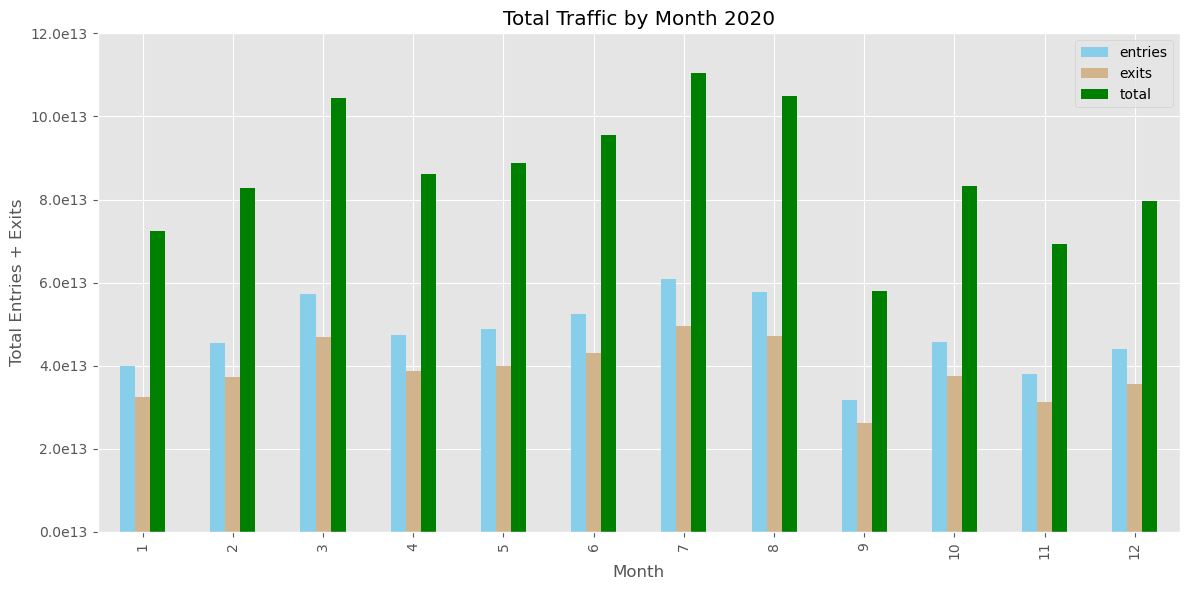

In [56]:
mta_2020['month'] = mta_2020['datetime'].dt.month

monthly_traffic = (
    mta_2020.groupby('month')[['entries', 'exits']]
    .sum()
    .assign(total=lambda df: df['entries'] + df['exits'])
)

monthly_traffic.plot(kind='bar', figsize=(12, 6), title='Total Traffic by Month 2020', color=['skyblue', 'tan', 'green'])

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*1e-13:.1f}e13'))
plt.ylim(0, 1.2e14)

plt.xlabel('Month')
plt.ylabel('Total Entries + Exits')
plt.tight_layout()
plt.show()


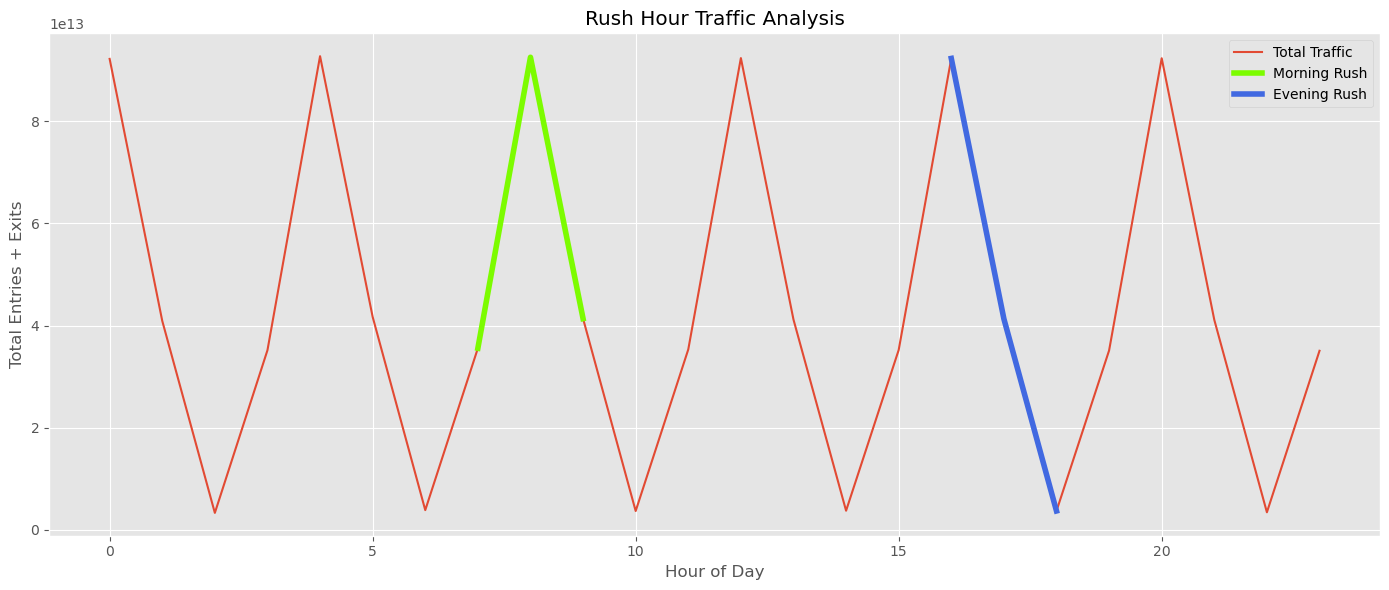

In [25]:
# Group by hour and summarize
hourly_traffic = (
    mta_2020.groupby('hour')[['entries', 'exits']]
    .sum()
    .assign(total=lambda df: df['entries'] + df['exits'])
)

# Highlight rush hours (e.g., 7AM-9AM and 4PM-6PM)
rush_hours = hourly_traffic.loc[(hourly_traffic.index >= 7) & (hourly_traffic.index <= 9)]
evening_rush = hourly_traffic.loc[(hourly_traffic.index >= 16) & (hourly_traffic.index <= 18)]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(hourly_traffic.index, hourly_traffic['total'], label='Total Traffic')
plt.plot(rush_hours.index, rush_hours['total'], label='Morning Rush', color='lawngreen', linewidth=4)
plt.plot(evening_rush.index, evening_rush['total'], label='Evening Rush', color='royalblue', linewidth=4)
plt.title('Rush Hour Traffic Analysis')
plt.xlabel('Hour of Day')
plt.ylabel('Total Entries + Exits')
plt.legend()
plt.tight_layout()
plt.show()